# Collaborative filtering
- Patrick Schaper ()
- Daniel-Alexandru Bejan (474404)

In [128]:
from IPython.core.display import HTML
from movie_display import movie_display
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


## Dataset analysis

In [129]:
# Load into a dataframe
movies = pd.read_csv('./dataset/movies.csv')
links = pd.read_csv('./dataset/links.csv')
ratings = pd.read_csv('./dataset/ratings.csv')
tags = pd.read_csv('./dataset/tags.csv')
df = pd.read_json('./dataset/imdbdata.json', orient='columns')


### Print data 

In [130]:
print(f"Number of ratings: {len(ratings)}")
print(f"Number of unique movieId's: {ratings['movieId'].nunique()}")
print(f"Number of unique users: {ratings['userId'].nunique()}")
print(f"Average number of ratings per user: {round(len(ratings)/ratings['userId'].nunique(), 2)}")
print(f"Average number of ratings per movie: {round(len(ratings)/ratings['movieId'].nunique(), 2)}")

Number of ratings: 100004
Number of unique movieId's: 9066
Number of unique users: 671
Average number of ratings per user: 149.04
Average number of ratings per movie: 11.03


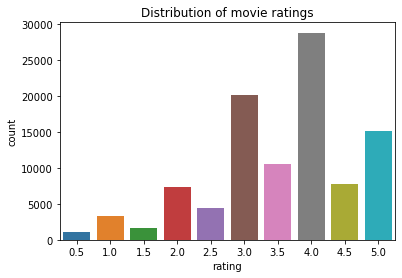

In [131]:
sns.countplot(x="rating", data=ratings)
plt.title("Distribution of movie ratings")
plt.show()

In [132]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.54.
Mean rating per user: 3.66.


In [133]:
mean_ratings = ratings.groupby('movieId')[['rating']].mean()
lowest_rated = mean_ratings['rating'].idxmin()
movies[movies['movieId'] == lowest_rated]

,movieId,title,genres
1062,1311,Santa with Muscles (1996),Comedy


In [134]:
highest_rated = mean_ratings['rating'].idxmax()
movies[movies['movieId'] == highest_rated]

,movieId,title,genres
50,53,Lamerica (1994),Adventure|Drama


In [135]:

movie_stats = ratings.groupby('movieId')[['rating']].agg(['count', 'mean'])
movie_stats.columns = movie_stats.columns.droplevel()

In [136]:
C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
    bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
    return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']
movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')

In [137]:
movie_stats = movie_stats.merge(movies[['movieId', 'title']])
movie_stats.sort_values('bayesian_avg', ascending=False).head()

,movieId,count,mean,bayesian_avg,title
284,318,311,4.487138,4.446203,"Shawshank Redemption, The (1994)"
695,858,200,4.487500,4.425014,"Godfather, The (1972)"
48,50,201,4.370647,4.314534,"Usual Suspects, The (1995)"
977,1221,135,4.385185,4.302614,"Godfather: Part II, The (1974)"
472,527,244,4.303279,4.259541,Schindler's List (1993)


In [138]:
movie_stats.sort_values('bayesian_avg', ascending=True).head()

,movieId,count,mean,bayesian_avg,title
2869,3593,19,1.210526,1.975099,Battlefield Earth (2000)
1242,1556,23,1.652174,2.183723,Speed 2: Cruise Control (1997)
2161,2701,47,2.031915,2.271446,Wild Wild West (1999)
489,546,17,1.735294,2.347912,Super Mario Bros. (1993)
1243,1562,47,2.148936,2.366224,Batman & Robin (1997)


In [139]:

movies['genres'] = movies['genres'].apply(lambda x: x.split("|"))
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


### Number of movie genres

In [140]:
from collections import Counter

genre_frequency = Counter(g for genres in movies['genres'] for g in genres)

print(f"There are {len(genre_frequency)} genres.")

genre_frequency

There are 20 genres.


Counter({'Adventure': 1117,
         'Animation': 447,
         'Children': 583,
         'Comedy': 3315,
         'Fantasy': 654,
         'Romance': 1545,
         'Drama': 4365,
         'Action': 1545,
         'Crime': 1100,
         'Thriller': 1729,
         'Horror': 877,
         'Mystery': 543,
         'Sci-Fi': 792,
         'Documentary': 495,
         'IMAX': 153,
         'War': 367,
         'Musical': 394,
         'Western': 168,
         'Film-Noir': 133,
         '(no genres listed)': 18})

In [141]:
print("The 5 most common genres: \n", genre_frequency.most_common(5))

The 5 most common genres: 
 [('Drama', 4365), ('Comedy', 3315), ('Thriller', 1729), ('Romance', 1545), ('Action', 1545)]


## User-item matrix

In [142]:
# Create a pivot table with userId as the index, movieId as the columns, and rating as the values
user_item_matrix = ratings.pivot_table(index='userId', columns='movieId', values='rating')

In [143]:
user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,NaN,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
668,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
669,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Similarity metrics

In [144]:
def calculate_similarity(df, similarity='none'):
    """
    Prepare the datafram for the cosine similarity
    Parameters
    ----------
    df : Pandas Dataframe

    similarity : string
    Returns
    -------
     dataframe : Pandas dataframe
    """
    if similarity == 'pearson':
        # centered zero matrix
        # Per slides: Subtract the mean (average) user rating from each user’s rating
        # (substracts the ROW mean)
        # 1. Subtract the average of a user from its ratings
        # 2. The negative values represent negative ratings, positive values represent positive ratings
        # 3. The value 0 is now the average rating for a user
        similarity_matrix = df.subtract(df.mean(axis=1), axis=0)   
    if similarity == 'adjusted':
        # Adjusted cosine similarity
        # Per slides: Subtract the average item rating from each user rating for a given item (when
        # we calculate the difference between users)
        # (substracts the COLUMN mean)
        similarity_matrix = (df - df.mean())
    # Per slides: 
    # Problem: low ratings and high ratings will have the same angle when
    # calculating the cosine similarity
    # ▪ Difference between A and B and A and C is small, whereas A and C are
    # almost opposite users
    # ▪ Solution: center around 0
    # Therefore we have to center everything around 0 filling the NaN values with 0. as follows
    similarity_matrix = df.fillna(0)
    # Calculating the cosine similarity
    similarity = cosine_similarity(similarity_matrix)
    # set the columns and index of the initial dataframe otherwise it would messup the indexes later
    return pd.DataFrame(similarity,index=df.index, columns=df.index)

#### Calculate similarity matrixes

In [145]:
cosine_similarity_matrix = calculate_similarity(user_item_matrix)

pearson_similarity_matrix = calculate_similarity(user_item_matrix, 'pearson')

ajusted_cosine_similarity_matrix = calculate_similarity(user_item_matrix, 'adjusted')

# Example for each similarity

### Cosine Similarity

In [146]:
from sklearn.metrics.pairwise import cosine_similarity
# cosine similarity
cosine_similarity_matrix = calculate_similarity(user_item_matrix)
# calc pearson similarity
pearson_similarity_matrix = calculate_similarity(user_item_matrix, 'pearson')
# calculate adjusted cosine similarity
adjusted_cosine_similarity_matrix = calculate_similarity(user_item_matrix, 'adjusted')

In [147]:
# sns.heatmap(cosine_similarity_matrix, cmap='viridis')
# sns.heatmap(pearson_similarity_matrix, cmap='viridis')
# sns.heatmap(ajusted_cosine_similarity_matrix, cmap='viridis')

#### Calculate the user average

In [148]:

# user_item_matrix.iloc[4][3]
user_item_matrix.mean(axis=1)


userId
1      2.550000
2      3.486842
3      3.568627
4      4.348039
5      3.910000
         ...   
667    3.647059
668    3.750000
669    3.351351
670    3.806452
671    3.917391
Length: 671, dtype: float64

## User-user recommendations

#### Converting the user-item matrix to user-user matrix

In [149]:
cosine_similarity_matrix

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,...,0.000000,0.000000,0.014474,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,...,0.477306,0.063202,0.077745,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,...,0.161205,0.064198,0.176134,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,...,0.114319,0.047228,0.136579,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,...,0.191029,0.021142,0.146173,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,0.000000,0.425462,0.124562,0.088735,0.058252,0.000000,0.232051,0.069005,0.066412,0.032653,...,0.342283,0.050754,0.074080,0.124214,0.351207,1.000000,0.091597,0.018416,0.153111,0.127995
668,0.000000,0.084646,0.124911,0.068483,0.042926,0.019563,0.058773,0.112366,0.194493,0.098561,...,0.074089,0.059010,0.093021,0.082525,0.114487,0.091597,1.000000,0.000000,0.178017,0.135387
669,0.062917,0.024140,0.080984,0.104309,0.038358,0.024583,0.073151,0.055143,0.029291,0.060549,...,0.015960,0.025953,0.077927,0.101707,0.028773,0.018416,0.000000,1.000000,0.042609,0.085202


In [150]:
user_id = 1
user_row = cosine_similarity_matrix.loc[1]

updated_df = user_row.drop(1)
updated_df.head()
updated_df.sort_values(ascending=False)

userId
325    0.371852
634    0.194093
341    0.162819
310    0.157524
207    0.152746
         ...   
392    0.000000
159    0.000000
160    0.000000
389    0.000000
2      0.000000
Name: 1, Length: 670, dtype: float64

In [151]:
def get_similar_users(user_id, user_item_matrix, similarity_strategy='none'):
    """"Create a dict with the most similar users and ranks them based on similarity """
    # get the similarity matrix based similarity strategy
    similarity_matrix = calculate_similarity(user_item_matrix, similarity_strategy)
    # drop the user itself
    similar_users = (similarity_matrix.loc[user_id]).drop(1)
    # sorting the value descending in order to get the most similar users first
    return similar_users.sort_values(ascending=False).head(10)

In [152]:
# # testing the method above
# # user_id= 2
# similar_users = get_similar_users(2)

# similar_users

# # print(similar_users.index.to_list)


# # user_item_matrix.loc[similar_users.index]

# # for user_id, similarity in pd.DataFrame(similar_users).iterrows():
# #     print(user_id)
#     # simlar_user = user_item_matrix.iloc[user_id].dropna()
#     # print(simlar_user)

# # users_movies = pd.DataFrame(user_item_matrix.iloc[lambda x: x % 2 == 0])
# # print(type(users_movies.columns)) 
# # droplist = [column for column in users_movies if 1 >= column <= 5]
# # print(droplist)
# # dropped_columns = users_movies.drop(droplist,inplace=True)

# # dropped_columns.head()

In [153]:
def get_recommendation_list(user_id, number_of_recommendations, similarity_strategy, debug=False):
    # get the similar users with the selected similarity strategy as pandas dataframe
    similar_user_data = get_similar_users(user_id, user_item_matrix, similarity_strategy)

    # print(similar_users)
    # get pandas dataframe with each users and their movies
    rated_movies_by_user = user_item_matrix.loc[user_id].dropna()
    # users_movies = pd.DataFrame(user_item_matrix.iloc[2])
    recommendations = []
    for user_id, similarity in similar_user_data.items():
        # select the user from the user_item matrix and drop the null values
        similar_user_movies = user_item_matrix.loc[user_id].dropna()
        # print('current user',similar_user_movies.tolist())
        for movie_id, rating in similar_user_movies.items():
            if movie_id not in rated_movies_by_user:
                # print('user_id', user_id, 'movie', movie_id, 'similarity',similarity, 'rating', rating)
                recommendations.append((movie_id, rating * similarity))
    # sort values descending
    # recommendations = initial_recommendation.sort_values(ascending=False).head(number_of_recommendations)
    # # return the movies id only
    # print(recommendations[:30])
    recommendations.sort(key=lambda tup: tup[1], reverse=True)
    # print(recommendations[:10])
    if (debug):
        print(len(recommendations))
        print(recommendations[:10])
    movies = []
    # put the movie ids into a list to be prepared for display in the notebook widgets
    for movie_id, _ in recommendations:
        movies.append(movie_id)
    
    return movies[:number_of_recommendations]

In [154]:
get_recommendation_list(2, 5, 'none', debug=True)

256
[(337, 2.9076414644054975), (318, 2.903710787282709), (21, 2.865482633185452), (32, 2.865482633185452), (316, 2.865482633185452), (329, 2.865482633185452), (435, 2.865482633185452), (318, 2.8562589278065835), (594, 2.8562589278065835), (6, 2.825565828064021)]


[337, 318, 21, 32, 316]

## Item-item recommendations

1. Select a user
2. Select the movies that the user has rated more than 3.5 stars
3. Based on the user 

Give N (configurable) recommendations for a given user U (configurable) based on the
movies the user U rated with at least 3.5 stars. Explain your implementation and the
strategy that you use for selecting the final recommendations.
Which means that we have to give the user N number of recommendations for a certain user(selectable) from the movies that he has rated with at least 3.5 stars.

In the UI we would have to:
1. N number of recommendations
2. U which user id
3. Select certain movie which is rated >= 3.5 stars

How to do the recommendations:
1. find similar items
2. Candidate selection (items you might recommend)
3. Score recommendation candidates
4. Filter candidates (top_n) recommendation

In [155]:
# Create item_user matrix
# The difference between the user_item matrix is that the movie id will be the index and the columns would be the user id
# Which means that when we calculated the similarity matrix we would calculate the mean and using the ratings from the users 
# Per slides: Both(pearson and adjusted cosine similarity) are applicable for user-user and item-item recommendations
# Simply switch around users and items in the formulas!
item_user_matrix = ratings.pivot_table(index='movieId', columns='userId', values='rating')

item_user_matrix.head(20)

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,4.0,NaN,...,NaN,4.0,3.5,NaN,NaN,NaN,NaN,NaN,4.0,5.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,5.0,4.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Calculating the similarity matrixes

In [156]:
# cosine similarity
item_item_cosine_similarity_matrix = calculate_similarity(item_user_matrix)
# calc pearson similarity
item_item_pearson_similarity_matrix = calculate_similarity(item_user_matrix, 'pearson')
# calculate adjusted cosine similarity
item_item_adjusted_cosine_similarity_matrix = calculate_similarity(item_user_matrix, 'adjusted')

In [157]:
item_item_pearson_similarity_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
movieId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.394511,0.306516,0.133614,0.245102,0.377086,0.278629,0.063031,0.117499,0.310689,...,0.055829,0.031902,0.079755,0.079755,0.079755,0.079755,0.079755,0.0,0.0,0.055829
2,0.394511,1.000000,0.217492,0.164651,0.278476,0.222003,0.207299,0.223524,0.113669,0.418124,...,0.000000,0.055038,0.068797,0.082557,0.082557,0.137594,0.068797,0.0,0.0,0.000000
3,0.306516,0.217492,1.000000,0.177012,0.370732,0.247499,0.435648,0.127574,0.306717,0.191255,...,0.000000,0.000000,0.000000,0.116226,0.116226,0.000000,0.000000,0.0,0.0,0.000000
4,0.133614,0.164651,0.177012,1.000000,0.179556,0.072518,0.184626,0.501513,0.254630,0.111447,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000
5,0.245102,0.278476,0.370732,0.179556,1.000000,0.272645,0.388476,0.194113,0.367941,0.246846,...,0.000000,0.176845,0.000000,0.117897,0.117897,0.000000,0.000000,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161944,0.079755,0.137594,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.0,0.0,0.000000
162376,0.079755,0.068797,0.000000,0.000000,0.000000,0.111103,0.000000,0.000000,0.000000,0.076835,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.0,0.0,0.000000
162542,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,1.0,0.000000


In [158]:
# For each similar item that has not been seen by the user, calculate the expected rating
# Using the similarity matrixes 
# In order to predict the rating we have to know the following and use the matrixes
# We have to know the movie id to which we want to predict and the user id as well
# Following we need the similarity matrix to find similar items and the item_user matrix
# Prediction formula used is R(m, u) = {∑ ⱼ S(m, j)R(j, u)}/ ∑ ⱼ S(m, j)
# R(m, u): the rating for movie m by user u
# S(m, j): the similarity between movie m and movie j
# j ∈ J where J is the set of the similar movies to movie m
# source: https://medium.com/@Sumeet_Agrawal/item-based-collaborative-filtering-4e64f65ae6ea
def rating_prediction(movie_id, user_id, user_item_matrix, similarity_matrix, debug=False):
    # rating from the user 
    # contains movie_id and the rating
    user_rating = user_item_matrix.loc[:, user_id].sort_values(ascending=False).dropna()
    # print('rating from user',user_rating)
    # the weights for our calculation
    # We look at the similarities between movie_id and the other movies 
    # and we sort and descending and pick 10 most similar items
    similarity_items_by_id = similarity_matrix.loc[movie_id][user_rating.index]
    # get the items that have a similarity greater than 0
    similarity_items_by_id = similarity_items_by_id[similarity_items_by_id > 0]
    # print('similar items by id',similarity_items_by_id)
    # as the weights sum to zero, can't be normalized
    if similarity_items_by_id.sum() == 0:
        # we have to calculate the mean of the user ratings and return it 
        return round(user_rating.mean(), 1)

    weighted_average = np.average(user_rating.loc[similarity_items_by_id.index], weights = similarity_items_by_id)
    # https://towardsdatascience.com/3-ways-to-compute-a-weighted-average-in-python-4e066de7a719
    predicted_rating = round(weighted_average, 1)
    if (debug):
        print('predicted', predicted_rating)
        print('user ratings', user_rating.loc[similarity_items_by_id.index])
        print('similar items by id',similarity_items_by_id)
    return predicted_rating

In [159]:
# movie_id 1208 user_id 571 expected  3.5
rating_prediction(1208, 571, item_user_matrix, item_item_pearson_similarity_matrix, debug=True)

predicted 3.7
user ratings movieId
18       5.0
3535     4.5
55765    4.5
53953    4.5
52973    4.5
34338    4.5
32       4.5
4343     4.5
4159     4.5
4973     4.5
88812    4.5
4865     4.0
84954    4.0
74789    4.0
72378    4.0
68554    4.0
54997    4.0
150      4.0
413      4.0
52462    4.0
51662    4.0
45440    4.0
27660    4.0
8977     4.0
8641     4.0
1917     4.0
2858     4.0
3354     4.0
2124     4.0
2329     4.0
88       3.5
55363    3.5
1608     3.5
47518    3.5
3745     3.5
39715    3.5
4792     3.5
3981     3.5
4238     3.5
2706     3.5
2572     3.5
6502     3.5
5872     3.5
5400     3.5
1208     3.5
27251    3.0
2683     3.0
50923    3.0
5015     3.0
1347     3.0
6287     3.0
4718     2.5
3273     2.5
1517     2.5
7293     2.5
5481     2.5
546      2.5
7173     2.0
2094     2.0
Name: 571, dtype: float64
similar items by id movieId
18       0.149027
3535     0.336325
55765    0.210481
53953    0.102754
52973    0.212436
34338    0.228769
32       0.405467
4343     0.219689


3.7

In [160]:
def recommend_movies_by_item(user_id, number_of_recommendations, item_user_matrix, user_item_matrix, similarity_matrix, debug=False):
   """
    Recommend Movies for a user, used for Item-Item
    Parameters
    ----------
    user_id : integer
    number_of_recommendations : integer
    item_user_matrix : Pandas dataframe
    user_item_matrix : Pandas dataframe
    similarity_matrix : Pandas dataframe
    debug : boolean False as default
    Returns
    -------
     recommendation_list : [(movie_id, predicted_rating)]
    """
   # 1. Take the k highest rated items of a user, for this we need the ones with more than 3.5
   highest_rated_items = user_item_matrix.loc[user_id].loc[lambda rating : rating >= 3.5].sort_values(ascending=False)
   # Filter ones rated with more than 3.5
   # highest_rated_items.loc[lambda rating : rating >= 1]
   # 2. Find j similar items to those k highest rated items
   similar_items_to_highest_items = similarity_matrix.loc[highest_rated_items.index]
   if debug:
      print('huighest rated items index, which is the id of the movie',highest_rated_items.index)
      print('huighest rated items', highest_rated_items)
      print('similar items', similar_items_to_highest_items)
   # 3. For each similar item that has not been seen by the user, calculate the expected rating
   # checking if the value is NaN by checking if it's equals to itself https://stackoverflow.com/a/944712
   unrated_items_by_user = user_item_matrix.loc[user_id].loc[lambda rating : rating != rating]
   if debug:
      print('unrated movies', unrated_items_by_user)
   recommendation_list = []
   for movie_id, _ in unrated_items_by_user.items():
      # print('movie_id', movie_id)
      predicted_rating = rating_prediction(movie_id, user_id, user_item_matrix, similarity_matrix)
      recommendation_list.append((movie_id, predicted_rating))
   # 4. Select the top n movies with the highest rating
   recommendation_list.sort(key=lambda tup: tup[1], reverse=True)
   return recommendation_list[:number_of_recommendations]

In [161]:
# recommend_movies_by_item(5, 3, item_user_matrix, user_item_matrix, item_item_pearson_similarity_matrix, debug=True)

# Validation
Possible validation methods:
- A-B testing
- RMSE
- Hit-rate

In [162]:
# User-User Hit-rate validation
# Split the data into a training set and a test set
# train_df, test_df = train_test_split(user_item_df, test_size=0.2)

# RMSE

1. Remove some test data from the dataset (remove those ratings from the training set)
2. Predict ratings for the missing items
3. Compare to the real values in the test data set

In [163]:
def calculate_rmse(test_dataframe, item_user_matrix, similarity_matrix):
    # Initialize the list of squared differences
    squared_differences = []
    # Iterate over the user-item pairs in the test set
    for user_id, row in test_df.iterrows():
        for movie_id in row.index:
            # Check if the row value is nana if so continue
            if (row[movie_id] != row[movie_id]):
                continue
            # Calculate the predicted rating
            predicted_rating = rating_prediction(movie_id, user_id, item_user_matrix, similarity_matrix)
            # print('movie_id', movie_id, 'user_id', user_id, 'expected ', row[movie_id],'predicted',predicted_rating)
            # Calculate the squared difference between the predicted and actual rating
            squared_differences.append((predicted_rating - row[movie_id]) ** 2)

    # Calculate the MSE as the average of the squared differences
    mse = np.mean(squared_differences)
    # Calculate the RMSE as the square root of the MSE
    return np.sqrt(mse)

In [164]:
# Split the data into a training set and a test set
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(user_item_matrix, test_size=0.1)

In [165]:
# Split the data into a training set and a test set
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(user_item_matrix, test_size=0.1)
test_df

movieId,1,2,3,4,5,6,7,8,9,10,...,161084,161155,161594,161830,161918,161944,162376,162542,162672,163949
userId,,,,,,,,,,,,,,,,,,,,,
637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
368,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
657,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
159,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,NaN,NaN,NaN,NaN,4.5,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
616,4.0,NaN,3.0,NaN,NaN,3.0,3.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
190,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [166]:
# on average this runs in 1.5 minutes
rmse_item_item_cosine = calculate_rmse(test_df, item_user_matrix, item_item_cosine_similarity_matrix)
rmse_item_item_pearson = calculate_rmse(test_df, item_user_matrix, item_item_pearson_similarity_matrix)
rmse_item_item_adjusted = calculate_rmse(test_df, item_user_matrix, item_item_adjusted_cosine_similarity_matrix)

print(f'RMSE Cosine: {rmse_item_item_cosine:.2f}')
print(f'RMSE Pearson: {rmse_item_item_pearson:.2f}')
print(f'RMSE Adjusted: {rmse_item_item_adjusted:.2f}')

RMSE Cosine: 0.86
RMSE Pearson: 0.86
RMSE Adjusted: 0.86


# Widgets implementation 

In [167]:
def get_indexes(imdb_id=[]):
    movies = []
    for x in range(len(imdb_id)):
        movieIndex = df.loc[df['imdbId'] == imdb_id[x]].index[0]
        movies.append(df.iloc[movieIndex])
    
    return movies

def displayRecommendations(recommendations=[]):
    movies = []
    for _, row in links.iterrows():
        if row['movieId'] in recommendations:
            movies.append(int(row['imdbId']))
    
    return get_indexes(movies)

In [168]:
# display(displayRecommendations([589, 1196]))

# movies = [df.iloc[522], df.iloc[953]]\
recommendations = displayRecommendations([337, 318, 21])
print(type(recommendations)) 
HTML(movie_display.show(recommendations))

<class 'list'>


In [169]:
def user_user_recommendations(selected_user, recommendations, similarity_strategy):
    if similarity_strategy == 0:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='none')
    if similarity_strategy == 1:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='pearson')
    if similarity_strategy == 2:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='adjusted')

    return recommendation_list

In [170]:
user_user_recommendations(2,3,0)

[337, 318, 21]

In [171]:
def item_item_recommendations(selected_user, recommendations, similarity_strategy):
    if similarity_strategy == 0:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='none')
    if similarity_strategy == 1:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='pearson')
    if similarity_strategy == 2:
        recommendation_list = get_recommendation_list(selected_user, recommendations, similarity_strategy='adjusted')

    return recommendation_list

In [172]:
item_item_recommendations(2, 3, 2)

[337, 318, 21]

In [173]:
from IPython.core.display_functions import clear_output
import ipywidgets as widgets

selected_user = widgets.Dropdown(
    options=list(x+1 for x in range(ratings['userId'].nunique())),
    description='Select a user:\n ',
    disabled=False,
    layout={'width': 'max-content'}
)
recommendations = widgets.IntText(
    min=0,
    value=3,
    description='Number of recommendations:\n ',
    disabled=False,
)
recommendation_method = widgets.RadioButtons(
    options=[('User-User',0), ('Item-Item',1)],
    description='Recommendation:',
    disabled=False
)
similarity_strategy = widgets.RadioButtons(
    options=[('Cosine',0), ('Pearson',1), ('Adjusted cosine',2)],
    description='Similarity metrics:',
    disabled=False
)
button = widgets.Button(
    description='Recommendation',
    disabled=False,
)

def execute_function(_):
    with out:
          clear_output()
          recommendation_list = []
          print(recommendation_method)
          if recommendation_method.value == 0:
            recommendation_list = user_user_recommendations(selected_user.value, recommendations.value, similarity_strategy.value)
          if recommendation_method.value == 1:
            recommendation_list = item_item_recommendations(selected_user.value, recommendations.value, similarity_strategy.value)
          print(f'Selected User: {selected_user.value}')
            
          print('Recommendation(s):')
          print(f'Got movies with the following ids as recommendations: {recommendation_list}')
          display(HTML(movie_display.show(displayRecommendations(recommendation_list))))
            
button.on_click(execute_function)
out = widgets.Output()

box = widgets.VBox([recommendations, selected_user, recommendation_method, similarity_strategy, button, out])
box